# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색깔, 각도 등을 약간씩 변형한 이미지들을 추가로 만들어 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용한다.
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

##### 이미지 다운로드
- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown`
- 코랩에는 설치 되어 있음.

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU 



In [2]:
import os
#zipfile모듈: Zip 압축파일을 다루는 모듈(압축하기, 풀기)
from zipfile import ZipFile

# 압축풀기: ZipFile(압축파일경로).extractall(풀경로)
with ZipFile(fname) as zipFile:
    zipFile.extractall(os.path.join('data','cats_and_dogs_small'))

# 하이퍼파라미터 정의

In [3]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224   # 모든 이미지데이터를 224, 224 로 resize해서 학습 시킬 것임.

## 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

In [5]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPool2D(padding="same")) #pool_size=(2,2), strides=(2,2) -> 절반으로 축소

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    # 출력 Layer (cats/dogs => dogs 일 확률을 출력하는 이진분류)
    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model

# ImageDataGenerator 생성

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = "data/cats_and_dogs_small/train"
valid_dir = "data/cats_and_dogs_small/validation"
test_dir = "data/cats_and_dogs_small/test"

In [8]:
# image augmentation을 적용하지 않고 학습.
# ImageDataGenerator: 파이프라인 처리방식 설정.
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [9]:
# ImageDataGenerator.flow_from_directory() : Image데이터 읽어오는 설정.
train_iter = train_datagen.flow_from_directory(train_dir,   #읽을 디렉토리 경로
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), #리사이즈
                                               class_mode='binary',  # 이진분류
                                               batch_size=N_BATCHS   # 배치크기
                                               )

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# iterator.class_indices : class와 class name을 알려준다.
train_iter.class_indices

{'cats': 0, 'dogs': 1}

In [11]:
# 에폭당 step 수를 조회
len(train_iter), len(valid_iter), len(test_iter)

(25, 13, 13)

In [12]:
# 배치크기만큼 데이터를 조회
batch = next(train_iter)
print(type(batch)) 
# 반환타입: 튜플 (X, y)
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape)

<class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(80, 224, 224, 3) (80,)


In [13]:
batch[1][:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [14]:
import numpy as np
# 1/225 롤 rescale했기 때문에 0 ~ 1 으로 정규화
np.min(batch[0][0]), np.max(batch[0][0])

(0.0, 0.9725491)

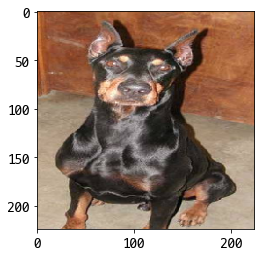

In [15]:
# 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(batch[0][4])
plt.show()

In [16]:
# 모델 생성
model = create_model()
# 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

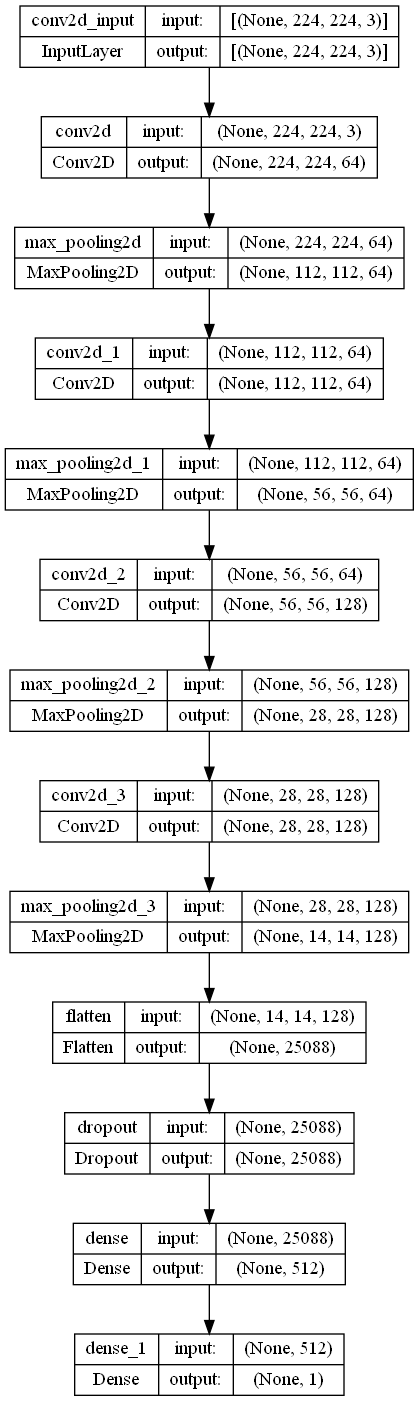

In [18]:
keras.utils.plot_model(model, show_shapes=True)


##  Model Training(학습)

In [19]:
# !rm -r drive

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
import os
# 모델을 저장할 디렉토리 (callback 을 이용해서 best 모델을 저장할 예정.)
#   구글드라이브 경로(/content/drive/MyDrive)에 저장.
save_dir = os.path.join("C:/playdata/playdata_workspace/practice/07_deep_learning", "cat_dog_model", "basic")
print(save_dir)
# 디렉토리 생성
os.makedirs(save_dir, exist_ok=True)

C:/playdata/playdata_workspace/practice/07_deep_learning\cat_dog_model\basic


In [22]:
# 모델 weight를 저장할 파일경로
save_file_path = os.path.join(save_dir, "weights_ckpt")
# 학습 도중 모델을 저장하는 callback
mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True,   # 모델의 weight만 저장
                                              save_best_only=True, # 모델 성능이 개선된 epoch만 저장
                                              monitor='val_loss', # 성능개선 지표로 확인할 평가지표
                                              verbose=2)
# 조기종료 callback. 성능개선이 안된면 학습을 종료
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            patience=5,
                                            verbose=1)

In [23]:
# ImageDataGenerator를 train/validation set으로 사용할 경우
#    steps_per_epoch: 1epoch 당 step 수
#    validation_steps: 검증 횟수(validation set을 몇개로 나눠서 검증할 지 횟수.) 
hist = model.fit(train_iter, 
                 epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.4875
Epoch 1: val_loss improved from inf to 0.69314, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\cat_dog_model\basic\weights_ckpt
25/25 [==============================] - 110s 4s/step - loss: 0.8128 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5200
Epoch 2: val_loss improved from 0.69314 to 0.68999, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\cat_dog_model\basic\weights_ckpt
25/25 [==============================] - 95s 4s/step - loss: 0.6924 - accuracy: 0.5200 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5190
Epoch 3: val_loss improved from 0.68999 to 0.68782, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\cat_dog_model\basic

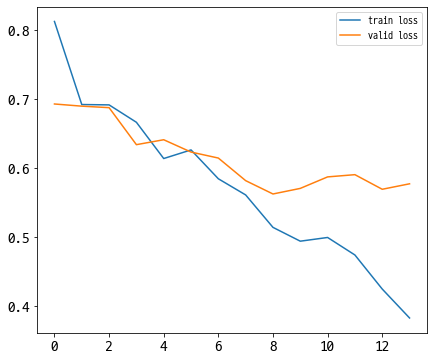

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.legend()
plt.show()

##### 저장된 모델 조회

In [25]:
# 파라미터만 저장한 경우
# 1. 모델을 생성  2. 생성된 모델의 파라미터를 저장한 파라미터로 변환.

save_model = create_model()
save_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [26]:
save_model.evaluate(test_iter)

13/13 [==============================] - 10s 729ms/step - loss: 0.6924 - accuracy: 0.5290


[0.6923567652702332, 0.5289999842643738]

In [27]:
save_model.load_weights(save_file_path)

In [28]:
save_model.evaluate(test_iter)

13/13 [==============================] - 10s 728ms/step - loss: 0.5856 - accuracy: 0.7120


[0.585568368434906, 0.7120000123977661]

# 새로운 데이터 추론

In [29]:
# 1. 이미지 파일 읽어오기.
# 2. resize (모델의 입력 shape 맞게) - 224
# 3. 전처리: 정규화 (1/255)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_preprocess_image(img_path):
    """
    img_path 이미지를 읽어서 추론할 수있는 ndarray로 변환해서 반환하는 함수
    """
    # 이미지파일 읽기 - target_size=(height, width) : 읽어오면서 resize
    raw_img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
    img_array = img_to_array(raw_img) # Pillow Image객체 -> ndarray 변환
    img_array = img_array[np.newaxis, ...] #batch axis 추가
    img_array = img_array.astype(np.float32) # uint8 -> float32 타입변환
    return img_array/255.0  #0~1 사이 실수로 정규화.


In [30]:
dog = load_preprocess_image('dog.jpg')
cat = load_preprocess_image('cat.jpg')
dog2 = load_preprocess_image('dog2.jpg')
dog.shape, cat.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [31]:
pred1 = save_model.predict(dog)
pred2 = save_model.predict(cat)
pred3 = save_model.predict(dog2)

1/1 [==============================] - 0s 30ms/step


In [32]:
# 1(dog)일 확률 추론.
print(pred1)
print(pred2)
print(pred3)

[[0.5531302]]
[[0.35673115]]
[[0.4977225]]


In [33]:
print(pred1)
result1 = np.where(pred1>0.5, '개', '고양이')[0]
result1

[[0.5531302]]


array(['개'], dtype='<U3')

In [34]:
print(pred2)
result2 = np.where(pred2>0.5, '개', '고양이')[0]
result2


[[0.35673115]]


array(['고양이'], dtype='<U3')

In [35]:
print(pred3)
result3 = np.where(pred3>0.5, '개', '고양이')[0]
result3

[[0.4977225]]


array(['고양이'], dtype='<U3')

In [36]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

##### 하이파러파미터

In [38]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224

##### ImageDataGenerator 생성

In [39]:
train_dir = 'data/cats_and_dogs_small/train'
valid_dir = 'data/cats_and_dogs_small/validation'
test_dir = 'data/cats_and_dogs_small/test'

In [40]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=40, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   fill_mode='constant'
                                   )

valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)


In [41]:
train_iter = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [42]:
batch_samples = next(train_iter)
len(batch_samples), type(batch_samples) # tuple (X, y)

(2, tuple)

In [43]:
batch_image_sample = batch_samples[0]
batch_image_sample.shape, batch_image_sample.dtype

((80, 224, 224, 3), dtype('float32'))

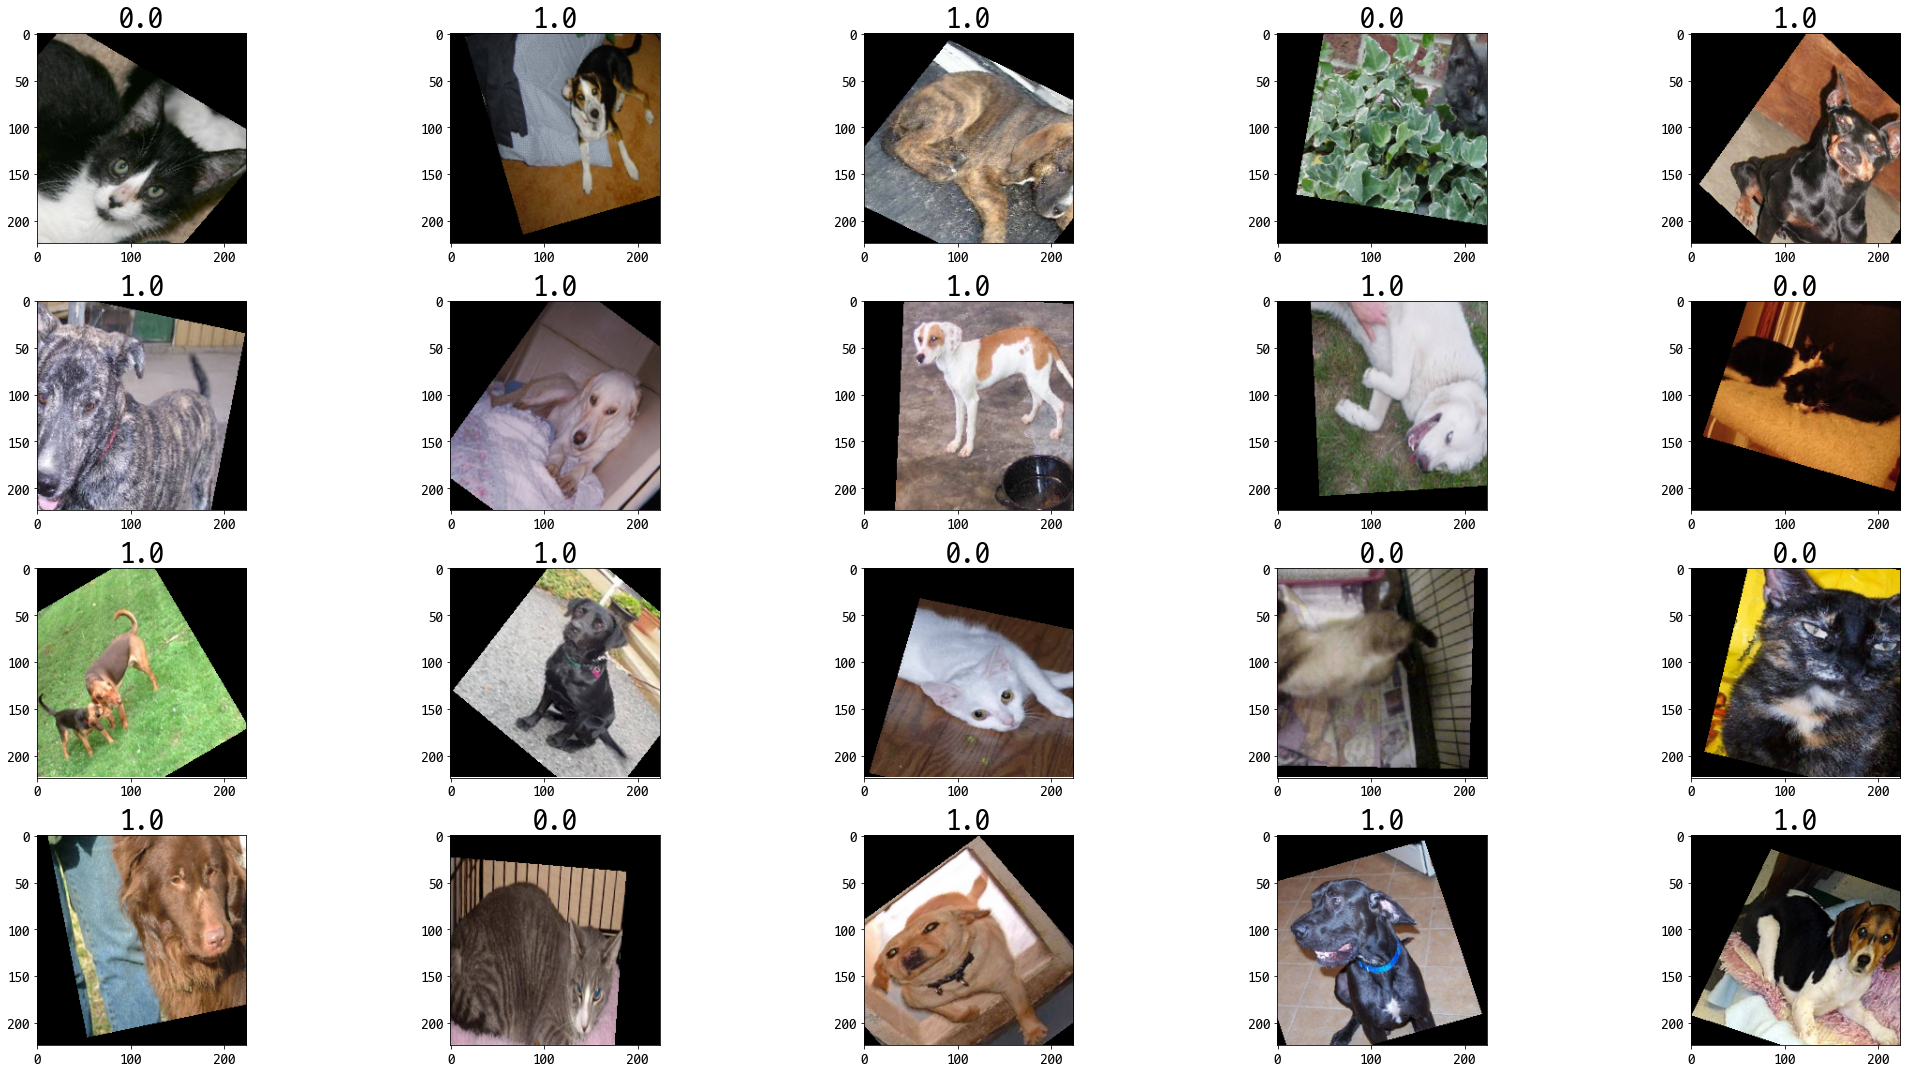

In [44]:
plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch_image_sample[i])
    plt.title(str(batch_samples[1][i]))

plt.tight_layout()
plt.show()

##### 모델 생성, 컴파일, 학습

In [45]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
save_dir = os.path.join("C:/playdata/playdata_workspace/practice/07_deep_learning", "augmentation")
os.makedirs(save_dir, exist_ok=True)

save_file_path = os.path.join(save_dir, 'weights_ckpt')

In [47]:

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [48]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.4970
Epoch 1: val_loss improved from inf to 0.69272, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\augmentation\weights_ckpt
25/25 [==============================] - 99s 4s/step - loss: 0.7636 - accuracy: 0.4970 - val_loss: 0.6927 - val_accuracy: 0.4990
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4955
Epoch 2: val_loss did not improve from 0.69272
25/25 [==============================] - 98s 4s/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6927 - val_accuracy: 0.5340
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5075
Epoch 3: val_loss improved from 0.69272 to 0.69211, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\augmentation\weights_ckpt
25/25 [==============================] - 99s 4s/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6921 - val_

Epoch 27/100
25/25 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.6775
Epoch 27: val_loss improved from 0.59101 to 0.58491, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\augmentation\weights_ckpt
25/25 [==============================] - 96s 4s/step - loss: 0.5804 - accuracy: 0.6775 - val_loss: 0.5849 - val_accuracy: 0.6860
Epoch 28/100
25/25 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.6915
Epoch 28: val_loss improved from 0.58491 to 0.57806, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\augmentation\weights_ckpt
25/25 [==============================] - 95s 4s/step - loss: 0.5765 - accuracy: 0.6915 - val_loss: 0.5781 - val_accuracy: 0.6830
Epoch 29/100
25/25 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.6990
Epoch 29: val_loss improved from 0.57806 to 0.57440, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\augmentation\weights_ckp

Epoch 54/100
25/25 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.7490
Epoch 54: val_loss did not improve from 0.51348
25/25 [==============================] - 97s 4s/step - loss: 0.5064 - accuracy: 0.7490 - val_loss: 0.5236 - val_accuracy: 0.7330
Epoch 55/100
25/25 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.7465
Epoch 55: val_loss improved from 0.51348 to 0.50969, saving model to C:/playdata/playdata_workspace/practice/07_deep_learning\augmentation\weights_ckpt
25/25 [==============================] - 98s 4s/step - loss: 0.4944 - accuracy: 0.7465 - val_loss: 0.5097 - val_accuracy: 0.7460
Epoch 56/100
25/25 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7880
Epoch 56: val_loss did not improve from 0.50969
25/25 [==============================] - 96s 4s/step - loss: 0.4660 - accuracy: 0.7880 - val_loss: 0.5219 - val_accuracy: 0.7540
Epoch 57/100
25/25 [==============================] - ETA: 0s - loss: 0.4833 

Epoch 81/100
25/25 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8105
Epoch 81: val_loss did not improve from 0.45300
25/25 [==============================] - 95s 4s/step - loss: 0.4135 - accuracy: 0.8105 - val_loss: 0.4723 - val_accuracy: 0.7880
Epoch 82/100
25/25 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8180
Epoch 82: val_loss did not improve from 0.45300
25/25 [==============================] - 97s 4s/step - loss: 0.4085 - accuracy: 0.8180 - val_loss: 0.4829 - val_accuracy: 0.7880
Epoch 83/100
25/25 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8390
Epoch 83: val_loss did not improve from 0.45300
25/25 [==============================] - 96s 4s/step - loss: 0.3696 - accuracy: 0.8390 - val_loss: 0.4532 - val_accuracy: 0.7980
Epoch 84/100
25/25 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8230
Epoch 84: val_loss did not improve from 0.45300
25/25 [==============================

##### 저장된 모델 Loading 후 평가(사용)

In [49]:
# 모델 생성 (weight만 저장했으므로 모델 생성후 저장된 weight로 변경.)
saved_model_aug = create_model()
saved_model_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
# 모델에 저장된 weight를 덮어씌우기.(변경)
saved_model_aug.load_weights(save_file_path)

In [50]:
saved_model_aug.evaluate(test_iter)

13/13 [==============================] - 10s 766ms/step - loss: 0.5090 - accuracy: 0.7740


[0.5089883208274841, 0.7739999890327454]

##### 새로운데이터 추론

In [51]:
dog2 = load_preprocess_image('dog.jpg')
cat2 = load_preprocess_image('cat.jpg')
dog3 = load_preprocess_image('image.jpg')

pred3 = saved_model_aug.predict(dog2)
pred4 = saved_model_aug.predict(cat2)
pred5 = saved_model_aug.predict(dog3)

1/1 [==============================] - 0s 30ms/step


In [52]:
print(pred3)
print(pred4)
print(pred5)

[[0.8808189]]
[[0.32610273]]
[[0.3805464]]


In [53]:
print(np.where(pred3>0.5, '개', '고양이'))

[['개']]
